<a href="https://colab.research.google.com/github/itimes-digital/Bootcamp-Analista-de-Machine-Learning-IGTI/blob/master/redes_neurais_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_hub as hub

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [49]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is NOT AVAILABLE


In [50]:
import pathlib

data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
                                   fname = 'flower_photos', untar=True)

data_dir = pathlib.Path(data_dir)

In [51]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [52]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['sunflowers', 'tulips', 'roses', 'dandelion', 'daisy'],
      dtype='<U10')

In [53]:
list(data_dir.glob('*'))

[PosixPath('/root/.keras/datasets/flower_photos/sunflowers'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/roses'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy')]

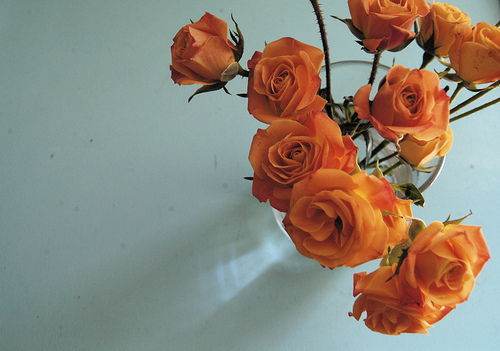

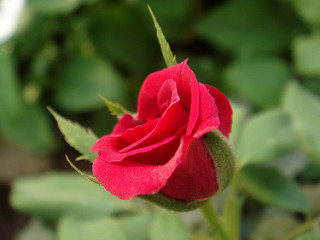

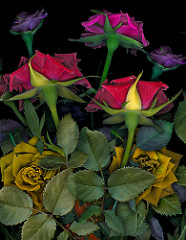

In [54]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

In [55]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [56]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [57]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [58]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, 
                      batch_size=BATCH_SIZE,
                      interpolation="bilinear")

In [59]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(data_dir, 
                                                    subset="validation", 
                                                    shuffle=False, 
                                                    **dataflow_kwargs)

Found 731 images belonging to 5 classes.


In [95]:
do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 2939 images belonging to 5 classes.


In [60]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')

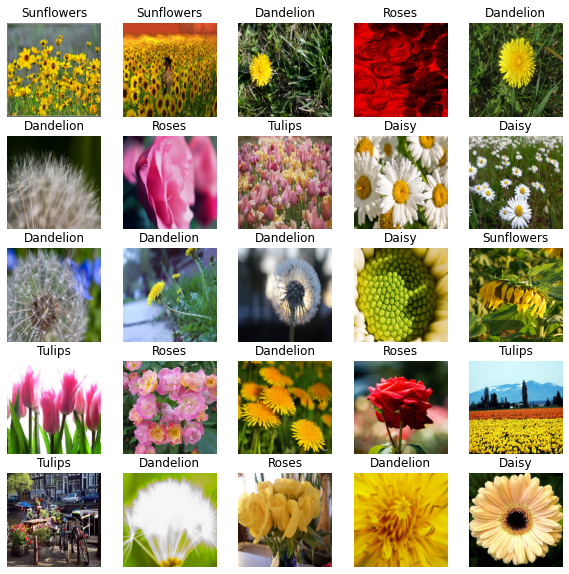

In [61]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [62]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/2351206867_084e57bd97.jpg'
b'/root/.keras/datasets/flower_photos/tulips/490541142_c37e2b4191_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/144686365_d7e96941ee_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/7367491658_9eb4dc2384_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/3021333497_b927cd8596.jpg'


In [63]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

In [64]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [65]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [66]:
labeled_ds = list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

In [67]:
for image, label in labeled_ds.take(1):
  print('Image shape: ', image.numpy().shape)
  print('Label:', label.numpy())

Image shape:  (224, 224, 3)
Label: [False False False False  True]


In [68]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [69]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

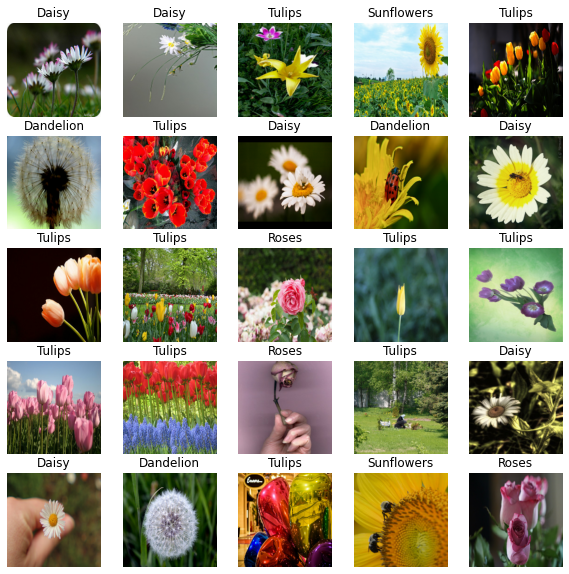

In [70]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [71]:
import time

default_timeout_steps = 1000

def timeit(ds, steps=default_timeout_steps):
  start = time.time()
  it = iter(ds)

  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.', end = '')
    print()
    end = time.time()

    duration = end-start
    print('{} batches: {} s'.format(steps, duration))
    print('{:0.5f} Images /s'.format(BATCH_SIZE * steps/duration))

In [72]:
do_fine_tuning = False

In [73]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [74]:
print('Construindo modelo com', MODULE_HANDLE)

Construindo modelo com https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


In [96]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape = IMAGE_SIZE + (3,)),
  hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
  tf.keras.layers.Dropout(rate = 0.2),
  tf.keras.layers.Dense(train_generator.num_classes,
                        kernel_regularizer = tf.keras.regularizers.l2(0.0001))
])

model.build((None, ) + IMAGE_SIZE + (3, ))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [97]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(lr = 0.005, momentum=0.9),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True, label_smoothing = 0.1),
    metrics = ['accuracy']
    )


In [101]:
steps_per_epoch = train_generator.samples
validation_steps = valid_generator.samples

hist = model.fit(
    train_generator,
    epochs = 5, steps_per_epoch = steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = validation_steps
).history

Epoch 1/5
  92/2939 [..............................] - ETA: 45:50 - loss: 0.6904 - accuracy: 0.8785WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 14695 batches). You may need to use the repeat() function when building your dataset.


  92/2939 [..............................] - 111s 1s/step - loss: 0.6904 - accuracy: 0.8785 - val_loss: 0.6899 - val_accuracy: 0.8755


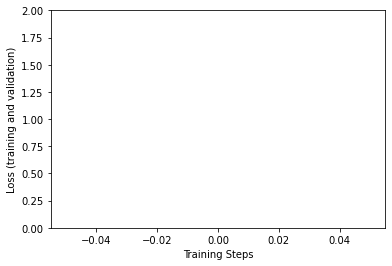

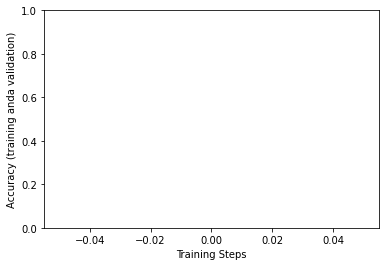

In [102]:
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

plt.figure()
plt.ylabel('Accuracy (training anda validation)')
plt.xlabel('Training Steps')
plt.ylim([0, 1])
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])

In [103]:
import pandas as pd
hist = pd.DataFrame(hist)
#hist['epoch'] = hist.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy
0,0.690429,0.87853,0.689948,0.875513


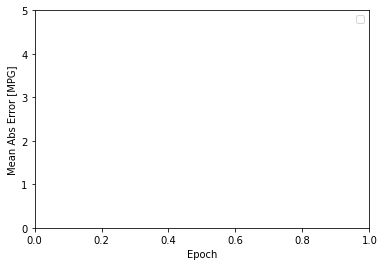

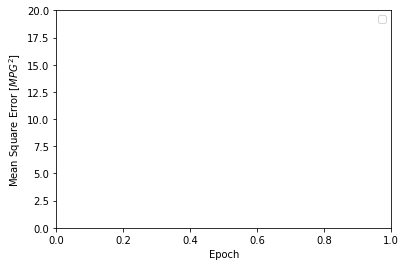

In [94]:
def plot_history(history):
  hist = pd.DataFrame(history)
  #hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  #plt.plot(hist['epoch'], hist['mae'],
  #        label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mae'],
  #         label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  #plt.plot(hist['epoch'], hist['mse'],
  #         label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mse'],
  #         label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(hist)